In [ ]:
!pip install spacy -U
!pip install spacy-transformers
!pip install pytesseract -U
!apt install tesseract-ocr
!apt install libtesseract-dev

In [17]:
!python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.7.3                         
Location         /usr/local/lib/python3.10/dist-packages/spacy
Platform         Linux-6.1.58+-x86_64-with-glibc2.35
Python version   3.10.12                       
Pipelines        en_core_web_sm (3.7.1)        



In [18]:
import spacy
import pandas as pd
import cv2 as cv
import pytesseract
import matplotlib.pyplot as plt

In [19]:
nlp_ner = spacy.load("/content/drive/MyDrive/4th_Year/DSC4996/Spacy/model-best")
df = pd.read_excel('/content/drive/MyDrive/4th_Year/DSC4996/Preprocessed_data.xlsx')

In [20]:
def pytes(image):
  result = pytesseract.image_to_string(image)
  result = ' '.join(result.split())
  result = result.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ')
  return result

(-0.5, 1413.5, 1999.5, -0.5)

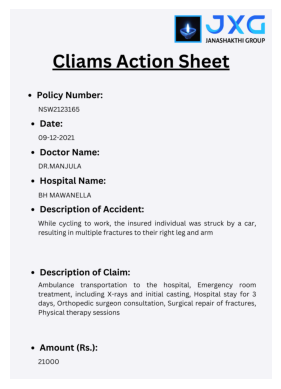

In [21]:
img = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4996/Claim_forms/19.png')
plt.imshow(img)
plt.axis('off')

In [22]:
input = pytes(img)
doc = nlp_ner(input)
spacy.displacy.render(doc, style="ent", jupyter=True)

In [23]:
Policy_no = None
Request_date = None
Doctor_name = None
Hospital_name = None
Amount = None
Types = {}
Types_in_claim_form = []

In [24]:
policy_number_temp = []

for entity in doc.ents:
  if entity.label_ == 'POLICY_NO':
    policy_number_temp.append(entity.text.replace('NGTO', 'NGT0').replace('L14', 'LI4'))
    Policy_no = '-'.join(policy_number_temp)
  elif entity.label_ == 'DATE':
    Request_date = entity.text
  elif entity.label_ == 'DOCTOR':
    Doctor_name = entity.text
  elif entity.label_ == 'HOSPITAL':
    Hospital_name = entity.text
  elif entity.label_ == 'AMOUNT':
    Amount = int(entity.text)
  else:
    if entity.label_ not in Types:
      Types[f'{entity.label_}'] = []
    if entity.label_ not in Types_in_claim_form:
      Types_in_claim_form.append(entity.label_)
    Types[f'{entity.label_}'].append(entity.text)

In [25]:
temp_df = df.iloc[list(df['PolicyNo'] == Policy_no)]
Types_in_DB = temp_df.groupby('TYPE').size().index.tolist()

registered_types = []
unregistered_types = []
for typ in Types_in_claim_form:
  if typ in Types_in_DB:
    registered_types.append(typ)
  else:
    unregistered_types.append(typ)
    continue

In [26]:
print('\n* * * * * * * * * * * * * * * * * * * * SUMMARY * * * * * * * * * * * * * * * * * * * *\n\n')
print(f'(1) POLICY NUMBER :- {Policy_no}\n')
line_1 = f'(1) POLICY NUMBER :- {Policy_no}'
print(f'(2) ACCIDENT DATE :- {Request_date}\n')
line_2 = f'(2) ACCIDENT DATE  :- {Request_date}'
print(f'(3) DOCTOR NAME   :- {Doctor_name}\n')
line_3 = f'(3) DOCTOR NAME   :- {Doctor_name}'
print(f'(4) HOSPITAL NAME :- {Hospital_name}\n')
line_4 = f'(4) HOSPITAL NAME :- {Hospital_name}'
print(f'(5) AMOUNT        :- Rs.{Amount}\n')
line_5 = f'(5) AMOUNT         :- Rs.{Amount}'
print('(6) CLAIM DETAILS :- ')
line_6 = '(6) CLAIM DETAILS  :- '
for key, val in Types.items():
  print('\t\t    ', key, ':-', ', '.join(val))


exp_date = temp_df.groupby('EXPIRYDATE').size().index[0]
exp_date = pd.to_datetime(exp_date, dayfirst = True)
Request_date = pd.to_datetime(Request_date, dayfirst = True)

if Request_date > exp_date:
    print(f'\n(7) CLAIM STATUS :- REJECTED\n')
    line_7 = '(7) CLAIM STATUS :- REJECTED'
    print('(8) REJECTION DETAILS :- All your life insurance coverages have expired.\n')
    line_8 = '(8) REJECTION DETAILS :- All your life insurance coverages have expired.'
else:
    if len(registered_types) != 0:
      total_suminsured = 0
      for typ in registered_types:
        temp_amount = sum(temp_df.iloc[list(temp_df['TYPE'] == typ)]['SUMINSURED'].tolist())
        total_suminsured += temp_amount
      if len(unregistered_types) != 0:
        if total_suminsured <= Amount:
          print('\n(7) CLAIM STATUS :- ACCEPTED\n')
          line_7 = '(7) CLAIM STATUS :- ACCEPTED'
          print(f'(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you are not registered for {", ".join(unregistered_types)} coverages. Therefore we can only payfor your {", ".join(registered_types)} coverages. We cannot pay Rs.{Amount}. We are obligated to pay Rs.{int(total_suminsured)} only.\n')
          line_8 = f'(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you are not registered for {", ".join(unregistered_types)} coverages. Therefore we can only payfor your {", ".join(registered_types)} coverages. We cannot pay Rs.{Amount}. We are obligated to pay Rs.{int(total_suminsured)} only.'
          print(f'(9) ACCEPTED PAYING AMOUNT :- Rs.{int(total_suminsured)}\n')
          line_9 = f'(9) ACCEPTED PAYING AMOUNT :- Rs.{int(total_suminsured)}'
        else:
          print('\n(7) CLAIM STATUS :- ACCEPTED\n')
          line_7 = '(7) CLAIM STATUS :- ACCEPTED'
          print(f'(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you are not registered for {", ".join(unregistered_types)} coverages. Therefore we can only pay for your {", ".join(registered_types)} coverages. We are obligated to pay Rs.{int(Amount)} only.\n')
          line_8 = f'(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you are not registered for {", ".join(unregistered_types)} coverages. Therefore we can only pay for your {", ".join(registered_types)} coverages. We are obligated to pay Rs.{int(Amount)} only.'
          print(f'(9) ACCEPTED PAYING AMOUNT :- Rs.{int(Amount)}\n')
          line_9 = f'(9) ACCEPTED PAYING AMOUNT :- Rs.{int(Amount)}'
      else:
        if total_suminsured <= Amount:
          print('\n(7) CLAIM STATUS :- ACCEPTED\n')
          line_7 = '(7) CLAIM STATUS :- ACCEPTED'
          print(f"(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you're sum insured coverage limit is reached. Therefor we cannot pay Rs.{Amount}. We are obligated to pay Rs.{int(total_suminsured)} only.\n")
          line_8 = f"(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you're sum insured coverage limit is reached. Therefor we cannot pay Rs.{Amount}. We are obligated to pay Rs.{int(total_suminsured)} only."
          print(f'(9) ACCEPTED PAYING AMOUNT :- Rs.{int(total_suminsured)}\n')
          line_9 = f'(9) ACCEPTED PAYING AMOUNT :- Rs.{int(total_suminsured)}'
        else:
          print('\n(7) CLAIM STATUS :- ACCEPTED')
          line_7 = '(7) CLAIM STATUS :- ACCEPTED'
          print(f'(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, We are obligated to pay Rs.{int(Amount)}.\n')
          line_8 = f'(8) PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, We are obligated to pay Rs.{int(Amount)}.'
          print(f'(9) ACCEPTED PAYING AMOUNT :- Rs.{Amount}\n')
          line_9 = f'(9) ACCEPTED PAYING AMOUNT :- Rs.{Amount}'
    else:
      print('\n(7) CLAIM STATUS :- REJECTED\n')
      line_7 = '(7) CLAIM STATUS :- REJECTED'
      print(f'(8) REJECTION DETAILS :- Dear valuable {Policy_no} policy holder, you are not registered for all of the coveragesyou have requested.\n')
      line_8 = f'(8) REJECTION DETAILS :- Dear valuable {Policy_no} policy holder, you are not registered for all of the coveragesyou have requested.'
      print(f'(9) UNREGISTERED COVERAGES :- {", ".join(unregistered_types)}\n')
      line_9 = f'(9) UNREGISTERED COVERAGES :- {", ".join(unregistered_types)}'
      print(f'(10)REGISTERED COVERAGES :- {", ".join(Types_in_DB)}')
      line_10 = f'(10)REGISTERED COVERAGES :- {", ".join(Types_in_DB)}'



* * * * * * * * * * * * * * * * * * * * SUMMARY * * * * * * * * * * * * * * * * * * * *


(1) POLICY NUMBER :- NSW2123165

(2) ACCIDENT DATE :- 09-12-2021

(3) DOCTOR NAME   :- DR.MANJULA

(4) HOSPITAL NAME :- BH MAWANELLA

(5) AMOUNT        :- Rs.21000

(6) CLAIM DETAILS :- 
		     PERSONAL ACCIDENT COVER :- Ambulance transportation
		     CASHLESS HOSPITAL COVER :- Emergency room treatment, X-rays, initial casting, Hospital stay, Orthopedic surgeon consultation, Physical therapy sessions
		     ADDITIONAL CRITICAL ILLNESS COVER :- Surgical repair

(7) CLAIM STATUS :- REJECTED

(8) REJECTION DETAILS :- Dear valuable NSW2123165 policy holder, you are not registered for all of the coveragesyou have requested.

(9) UNREGISTERED COVERAGES :- PERSONAL ACCIDENT COVER, CASHLESS HOSPITAL COVER, ADDITIONAL CRITICAL ILLNESS COVER

(10)REGISTERED COVERAGES :- ADDITIONAL ACCIDENT COVER, ADDITIONAL HOSPITAL COVER, BASIC COVER


In [27]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [28]:
img_out = cv.imread('/content/drive/MyDrive/4th_Year/DSC4996/claim details.png')
img_out = cv.cvtColor(img_out, cv.COLOR_BGR2RGB)
img_out.shape

(2000, 1414, 3)

# line 1

In [39]:
x = 130
y = 600
img_out1 = img_out.copy()
img_out1 = cv.putText(img = img_out1,
                   text = line_1,
                   org = (x, y),
                   fontFace = cv.FONT_HERSHEY_TRIPLEX ,
                   fontScale = .8,
                   color = (0,0,0),
                   thickness = 1)
fig = plt.figure(figsize=(10, 15))
y += 60
# plt.imshow(img_out1)

<Figure size 1000x1500 with 0 Axes>

#line 2

In [40]:
img_out2 = img_out1.copy()
img_out2 = cv.putText(img = img_out2,
                   text = line_2,
                   org = (x, y),
                   fontFace = cv.FONT_HERSHEY_TRIPLEX ,
                   fontScale = .8,
                   color = (0,0,0),
                   thickness = 1)
fig = plt.figure(figsize=(10, 15))
y += 60
# plt.imshow(img_out2)

<Figure size 1000x1500 with 0 Axes>

line 3

In [41]:
img_out3 = img_out2.copy()
img_out3 = cv.putText(img = img_out3,
                   text = line_3,
                   org = (x, y),
                   fontFace = cv.FONT_HERSHEY_TRIPLEX ,
                   fontScale = .8,
                   color = (0,0,0),
                   thickness = 1)
fig = plt.figure(figsize=(10, 15))
y += 60
# plt.imshow(img_out3)

<Figure size 1000x1500 with 0 Axes>

#line 4

In [42]:
img_out4 = img_out3.copy()
img_out4 = cv.putText(img = img_out4,
                   text = line_4,
                   org = (x, y),
                   fontFace = cv.FONT_HERSHEY_TRIPLEX ,
                   fontScale = .8,
                   color = (0,0,0),
                   thickness = 1)
fig = plt.figure(figsize=(10, 15))
y += 60
# plt.imshow(img_out4)

<Figure size 1000x1500 with 0 Axes>

#line 5

In [43]:
img_out5 = img_out4.copy()
img_out5 = cv.putText(img = img_out5,
                   text = line_5,
                   org = (x, y),
                   fontFace = cv.FONT_HERSHEY_TRIPLEX ,
                   fontScale = .8,
                   color = (0,0,0),
                   thickness = 1)
fig = plt.figure(figsize=(10, 15))
y += 60
# plt.imshow(img_out5)

<Figure size 1000x1500 with 0 Axes>

#line 6

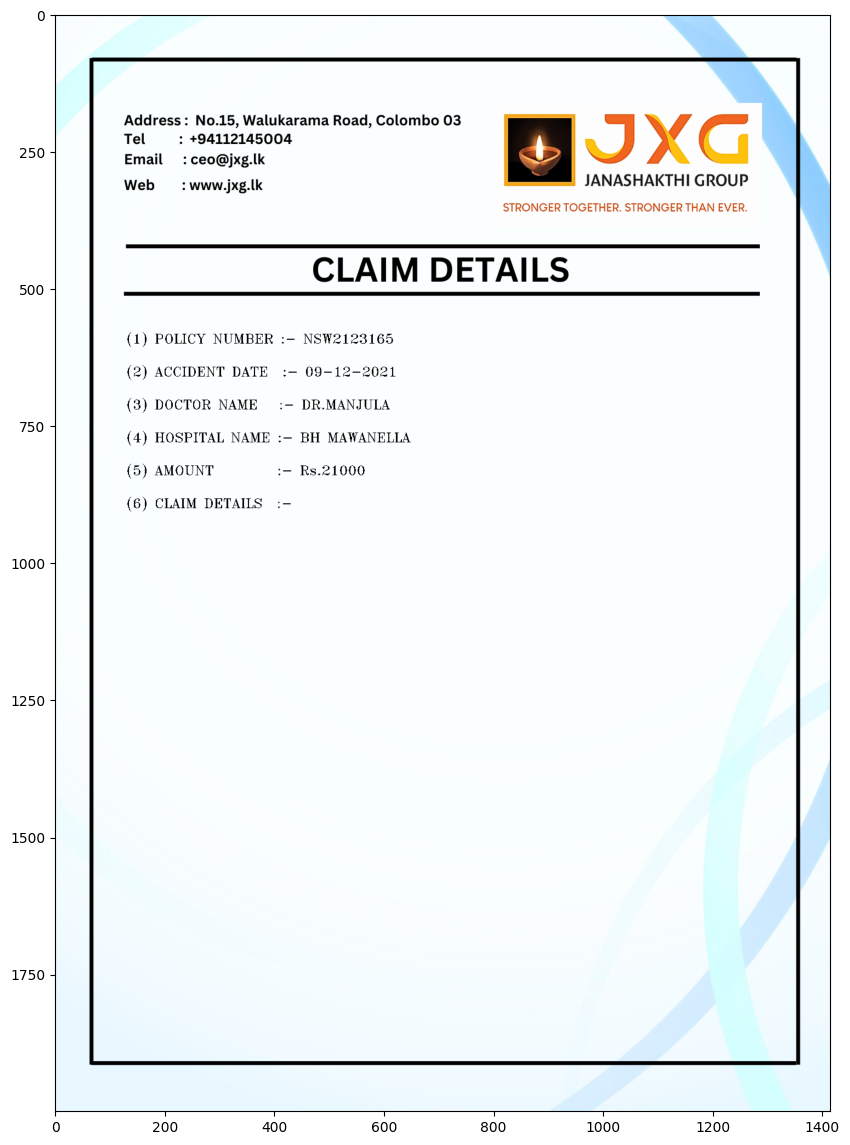

In [44]:
img_out6 = img_out5.copy()
img_out6 = cv.putText(img = img_out6,
                   text = line_6,
                   org = (x, y),
                   fontFace = cv.FONT_HERSHEY_TRIPLEX ,
                   fontScale = .8,
                   color = (0,0,0),
                   thickness = 1)
fig = plt.figure(figsize=(10, 15))
y += 60
plt.imshow(img_out6)

		     PERSONAL ACCIDENT COVER :- Ambulance transportation
		     CASHLESS HOSPITAL COVER :- Emergency room treatment, X-rays, initial casting, Hospital stay, Orthopedic surgeon consultation, Physical therapy sessions
		     ADDITIONAL CRITICAL ILLNESS COVER :- Surgical repair


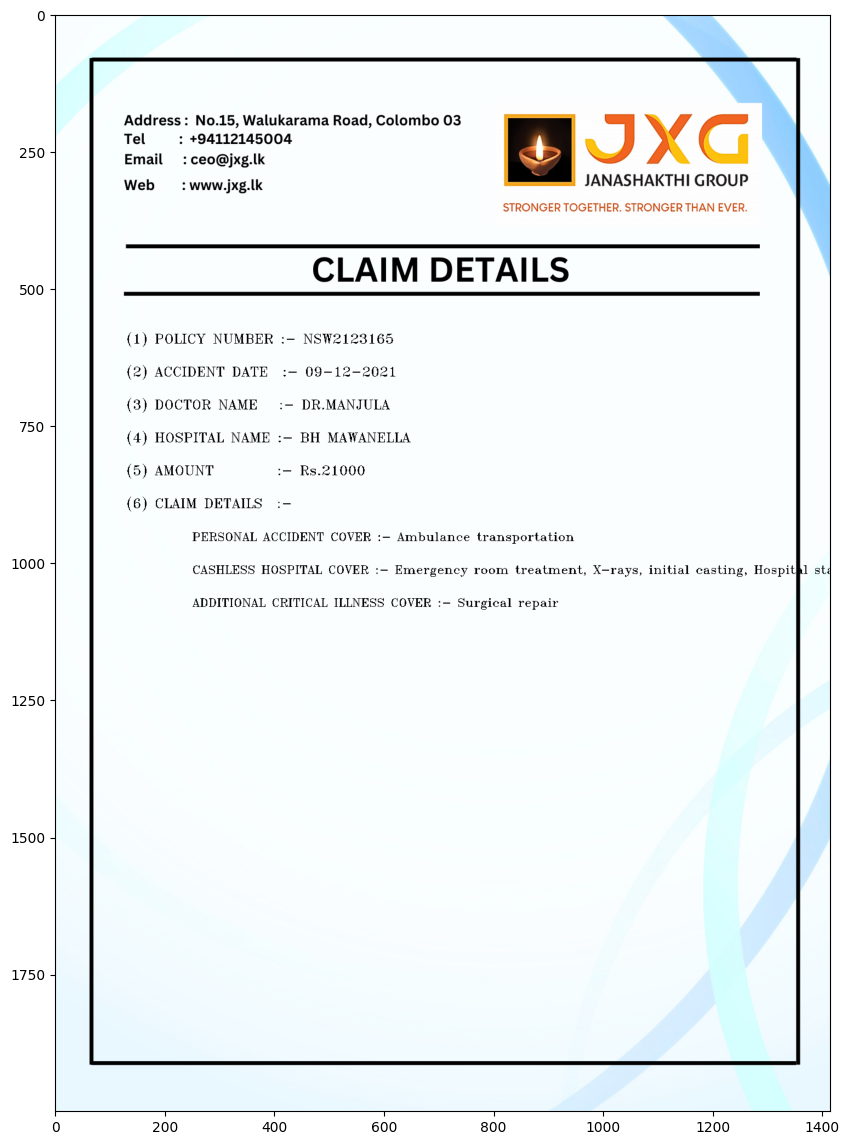

In [45]:
x = 250
claiming_coverages = []
for key, val in Types.items():
  print('\t\t    ', key, ':-', ', '.join(val))
  temp = f"{key} :- {', '.join(val)}"
  claiming_coverages.append(temp)

img_out7 = img_out6.copy()
for tmp in claiming_coverages:
  img_out7 = cv.putText(img = img_out7,
                   text = tmp,
                   org = (x, y),
                   fontFace = cv.FONT_HERSHEY_TRIPLEX ,
                   fontScale = .7,
                   color = (0,0,0),
                   thickness = 1)
  y += 60
fig = plt.figure(figsize=(10, 15))
plt.imshow(img_out7)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



* * * * * * * * * * * * * * * * * * * * SUMMARY * * * * * * * * * * * * * * * * * * * *


(1)  POLICY NUMBER :- NGT012218551

(2)  ACCIDENT DATE :- 21-03-2023

(3)  DOCTOR NAME   :- DR.RAMYA

(4)  HOSPITAL NAME :- LANKA HOSPITAL

(5)  AMOUNT        :- Rs.950000

(6)  CLAIM DETAILS :- 
		     CRITICAL ILLNESS COVER :- Initial hearing tests, hearing aids
		     BASIC COVER :- consultations
		     CASHLESS HOSPITAL COVER :- Medical expenses
		     PERSONAL ACCIDENT COVER :- disability benefits

(7)  CLAIM STATUS :- ACCEPTED CLAIM REQUEST

(8)  PAYMENT NOTE :- Dear valuable NGT012218551 policy holder, you are not registered for CRITICAL ILLNESS COVER, CASHLESS HOSPITAL COVER coverages.
                     Therefore we can only pay for your BASIC COVER, PERSONAL ACCIDENT COVER coverages. We cannot pay Rs.950000. We are obligated to pay Rs.550000 only.


* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *



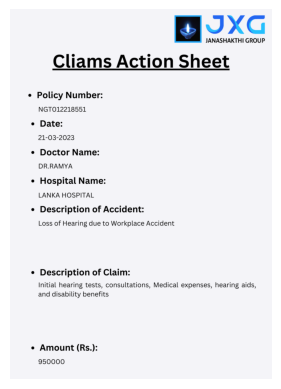

In [ ]:
import spacy
import pandas as pd
import cv2 as cv
import pytesseract
import matplotlib.pyplot as plt


def pytes(image):
  result = pytesseract.image_to_string(image)
  result = ' '.join(result.split())
  result = result.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ')
  return result


nlp_ner = spacy.load("/content/drive/MyDrive/4th_Year/DSC4996/Spacy/model-best")
df = pd.read_excel('/content/drive/MyDrive/4th_Year/DSC4996/Preprocessed_data.xlsx')


img = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4996/Claim_forms/44.png')
plt.imshow(img)
plt.axis('off')


input = pytes(img)
doc = nlp_ner(input)
spacy.displacy.render(doc, style="ent", jupyter=True)


Policy_no = None
Request_date = None
Doctor_name = None
Hospital_name = None
Amount = None
Types = {}
Types_in_claim_form = []


policy_number_temp = []
for entity in doc.ents:
  if entity.label_ == 'POLICY_NO':
    policy_number_temp.append(entity.text.replace('NGTO', 'NGT0').replace('L14', 'LI4'))
    Policy_no = '-'.join(policy_number_temp)
  elif entity.label_ == 'DATE':
    Request_date = entity.text
  elif entity.label_ == 'DOCTOR':
    Doctor_name = entity.text
  elif entity.label_ == 'HOSPITAL':
    Hospital_name = entity.text
  elif entity.label_ == 'AMOUNT':
    Amount = int(entity.text)
  else:
    if entity.label_ not in Types:
      Types[f'{entity.label_}'] = []
    if entity.label_ not in Types_in_claim_form:
      Types_in_claim_form.append(entity.label_)
    Types[f'{entity.label_}'].append(entity.text)


temp_df = df.iloc[list(df['PolicyNo'] == Policy_no)]
Types_in_DB = temp_df.groupby('TYPE').size().index.tolist()


registered_types = []
unregistered_types = []
for typ in Types_in_claim_form:
  if typ in Types_in_DB:
    registered_types.append(typ)
  else:
    unregistered_types.append(typ)
    continue


print('\n* * * * * * * * * * * * * * * * * * * * SUMMARY * * * * * * * * * * * * * * * * * * * *\n\n')
print(f'(1)  POLICY NUMBER :- {Policy_no}\n')
print(f'(2)  ACCIDENT DATE :- {Request_date}\n')
print(f'(3)  DOCTOR NAME   :- {Doctor_name}\n')
print(f'(4)  HOSPITAL NAME :- {Hospital_name}\n')
print(f'(5)  AMOUNT        :- Rs.{Amount}\n')
print('(6)  CLAIM DETAILS :- ')
for key, val in Types.items():
  print('\t\t    ', key, ':-', ', '.join(val))


exp_date = temp_df.groupby('EXPIRYDATE').size().index[0]
exp_date = pd.to_datetime(exp_date, dayfirst = True)
Request_date = pd.to_datetime(Request_date, dayfirst = True)

if Request_date > exp_date:
  print('\n(7)  CLAIM STATUS :- REJECTED CLAIM REQUEST\n')
  print(f"(8)  REJECTION DETAILS :- All your life insurance coverages have expired.")
else:
  print('\n(7)  CLAIM STATUS :- ACCEPTED CLAIM REQUEST\n')
  if len(registered_types) != 0:
    total_suminsured = 0
    for typ in registered_types:
      temp_amount = sum(temp_df.iloc[list(temp_df['TYPE'] == typ)]['SUMINSURED'].tolist())
      total_suminsured += temp_amount
    if len(unregistered_types) != 0:
      if total_suminsured <= Amount:
        print(f'''(8)  PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you are not registered for {", ".join(unregistered_types)} coverages.
                     Therefore we can only pay for your {", ".join(registered_types)} coverages. We cannot pay Rs.{Amount}. We are obligated to pay Rs.{int(total_suminsured)} only.''')
      else:
        print(f'''(8)  PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you are not registered for {", ".join(unregistered_types)} coverages. Therefore we can only pay for your {", ".join(registered_types)} coverages.
                     We are obligated to pay Rs.{(Amount)} only.''')
    else:
      if total_suminsured <= Amount:
        print(f'''(8)  PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, you're sum insured coverage limit is reached. Therefor we cannot pay Rs.{Amount}. We are obligated to pay Rs.{int(total_suminsured)} only.''')
      else:
        print(f'''(8)  PAYMENT NOTE :- Dear valuable {Policy_no} policy holder, We are obligated to pay Rs.{(Amount)} only.''')
  else:
    print('\n(8)  CLAIM STATUS :- REJECTED CLAIM REQUEST\n')
    print(f"(9)  REJECTION DETAILS :- You are not registered for all of the coverages you have requested.\n")
    print(f'(10) UNREGISTERED COVERAGES :- {", ".join(unregistered_types)}\n')
    print(f"(11) REGISTERED COVERAGES :- {', '.join(Types_in_DB)}")

print('\n\n* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')